In [2]:
import boto3
import sagemaker
import pandas as pd
import seaborn as sns
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
s3_client = boto3.client('s3', region_name='us-east-1')
bucket_name = 'team1ads508finalproject'

In [4]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

s3_public = "s3://team1ads508finalproject"

s3_private = "s3://{}/ADS508_project".format(bucket)

!aws s3 cp --recursive $s3_public/ $s3_private/

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
copy: s3://team1ads508finalproject/bureau.csv to s3://sagemaker-us-east-1-654654578488/ADS508_project/bureau.csv
copy: s3://team1ads508finalproject/previous_application.csv to s3://sagemaker-us-east-1-654654578488/ADS508_project/previous_application.csv
copy: s3://team1ads508finalproject/application_train.csv to s3://sagemaker-us-east-1-654654578488/ADS508_project/application_train.csv


In [5]:
print(s3_private)

s3://sagemaker-us-east-1-654654578488/ADS508_project


In [6]:
%store

Stored variables and their in-db values:


In [7]:
database_name = "dsoaws"

In [8]:
#Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [9]:
conn = connect(region_name='us-east-1', s3_staging_dir=s3_staging_dir)

In [10]:
# SQL queries for each of the csv's
sql_queries = {
    'bureau': 'SELECT * FROM bureau LIMIT 30000',
    'previous_application': 'SELECT * FROM previous_application LIMIT 30000',
    'application': 'SELECT * FROM application LIMIT 30000'
}

# Fetch data and convert to DataFrames
bureau_df = pd.read_sql(sql_queries['bureau'], conn)
prev_app_df = pd.read_sql(sql_queries['previous_application'], conn)
app_df = pd.read_sql(sql_queries['application'], conn)

# Display each pandas Dataframe
print("\nbureau_df:")
print(bureau_df.head())

print("\nprev_app_df:")
print(prev_app_df.head())

print("\napp_df:")
print(app_df.head())

/tmp/ipykernel_6193/3111011900.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bureau_df = pd.read_sql(sql_queries['bureau'], conn)
/tmp/ipykernel_6193/3111011900.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prev_app_df = pd.read_sql(sql_queries['previous_application'], conn)
/tmp/ipykernel_6193/3111011900.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_df = pd.read_sql(sql_queries['application'], conn)



bureau_df:
   sk_id_curr  sk_id_bureau credit_active credit_currency  days_credit  \
0    117007.0     5719964.0        Active      currency 1      -1050.0   
1    117007.0     5719965.0        Active      currency 1       -357.0   
2    200268.0     5719966.0        Closed      currency 1       -536.0   
3    200268.0     5719967.0        Active      currency 1       -283.0   
4    200268.0     5719968.0        Active      currency 1       -155.0   

   credit_day_overdue  days_credit_enddate  days_enddate_fact  \
0                 0.0                  NaN                NaN   
1                 0.0                374.0                NaN   
2                 0.0                -81.0             -130.0   
3                 0.0                815.0                NaN   
4                 0.0                241.0                NaN   

   amt_credit_max_overdue  cnt_credit_prolong  amt_credit_sum  \
0                     NaN                 0.0       261000.00   
1                     

In [11]:
# Aggregate data for bureau_df
bureau_df_grouped = bureau_df.groupby('sk_id_curr').agg('first').reset_index()

# Aggregate data for prev_app_df
prev_app_df_grouped = prev_app_df.groupby('sk_id_curr').agg('first').reset_index()

# Aggregate data for app_df
app_df_grouped = app_df.groupby('sk_id_curr').agg('first').reset_index()

# Concat DataFrames
aggregated_df = pd.concat([bureau_df_grouped, prev_app_df_grouped, app_df_grouped], ignore_index=True)

print(aggregated_df.head())

   sk_id_curr  sk_id_bureau credit_active credit_currency  days_credit  \
0    100045.0     5377608.0        Closed      currency 1       -733.0   
1    100053.0     5723577.0        Closed      currency 1      -1764.0   
2    100113.0     5732198.0        Closed      currency 1      -1981.0   
3    100270.0     6728606.0        Closed      currency 1       -742.0   
4    100359.0     6071567.0        Closed      currency 1      -2238.0   

   credit_day_overdue  days_credit_enddate  days_enddate_fact  \
0                 0.0               -337.0             -608.0   
1                 0.0               -648.0             -648.0   
2                 0.0              -1616.0            -1617.0   
3                 0.0               -591.0             -620.0   
4                 0.0              -1145.0            -1678.0   

   amt_credit_max_overdue  cnt_credit_prolong  ...  flag_document_18  \
0                     0.0                 0.0  ...               NaN   
1                   

In [12]:
duplicates = aggregated_df.duplicated(subset=['sk_id_curr'])
print("Duplicate rows:", duplicates.sum())

Duplicate rows: 2790


In [13]:
final_df = aggregated_df.drop_duplicates()
duplicates = final_df.duplicated(subset=['sk_id_curr'])
print("Duplicate rows:", duplicates.sum())

Duplicate rows: 2790


In [14]:
print(aggregated_df.columns)

Index(['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency',
       'days_credit', 'credit_day_overdue', 'days_credit_enddate',
       'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
       ...
       'flag_document_18', 'flag_document_19', 'flag_document_20',
       'flag_document_21', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object', length=166)


Bureau EDA

In [15]:
bureau_df

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,117007.0,5719964.0,Active,currency 1,-1050.0,0.0,NaN,NaN,NaN,0.0,261000.00,17689.50,NaN,0.0,Credit card,-16.0,742.500
1,117007.0,5719965.0,Active,currency 1,-357.0,0.0,374.0,NaN,0.0,0.0,525700.94,312804.22,0.00,0.0,Consumer credit,-22.0,27278.596
2,200268.0,5719966.0,Closed,currency 1,-536.0,0.0,-81.0,-130.0,NaN,0.0,167144.40,0.00,NaN,0.0,Consumer credit,-122.0,NaN
3,200268.0,5719967.0,Active,currency 1,-283.0,0.0,815.0,NaN,NaN,0.0,67500.00,67461.75,38.25,0.0,Credit card,-58.0,NaN
4,200268.0,5719968.0,Active,currency 1,-155.0,0.0,241.0,NaN,NaN,0.0,80190.00,59652.00,0.00,0.0,Consumer credit,-32.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,290742.0,6729713.0,Active,currency 1,-2859.0,0.0,-2515.0,NaN,NaN,0.0,180000.00,NaN,NaN,0.0,Loan for business development,-2324.0,NaN
29996,290742.0,6729715.0,Active,currency 1,-1967.0,0.0,-1864.0,NaN,NaN,0.0,135000.00,NaN,NaN,0.0,Credit card,-1864.0,NaN
29997,290742.0,6729717.0,Active,currency 1,-1791.0,0.0,-754.0,NaN,NaN,0.0,1237500.00,NaN,NaN,0.0,Consumer credit,-846.0,NaN
29998,290742.0,6729718.0,Active,currency 1,-2509.0,0.0,785.0,NaN,NaN,0.0,492750.00,472144.50,NaN,0.0,Credit card,-6.0,NaN


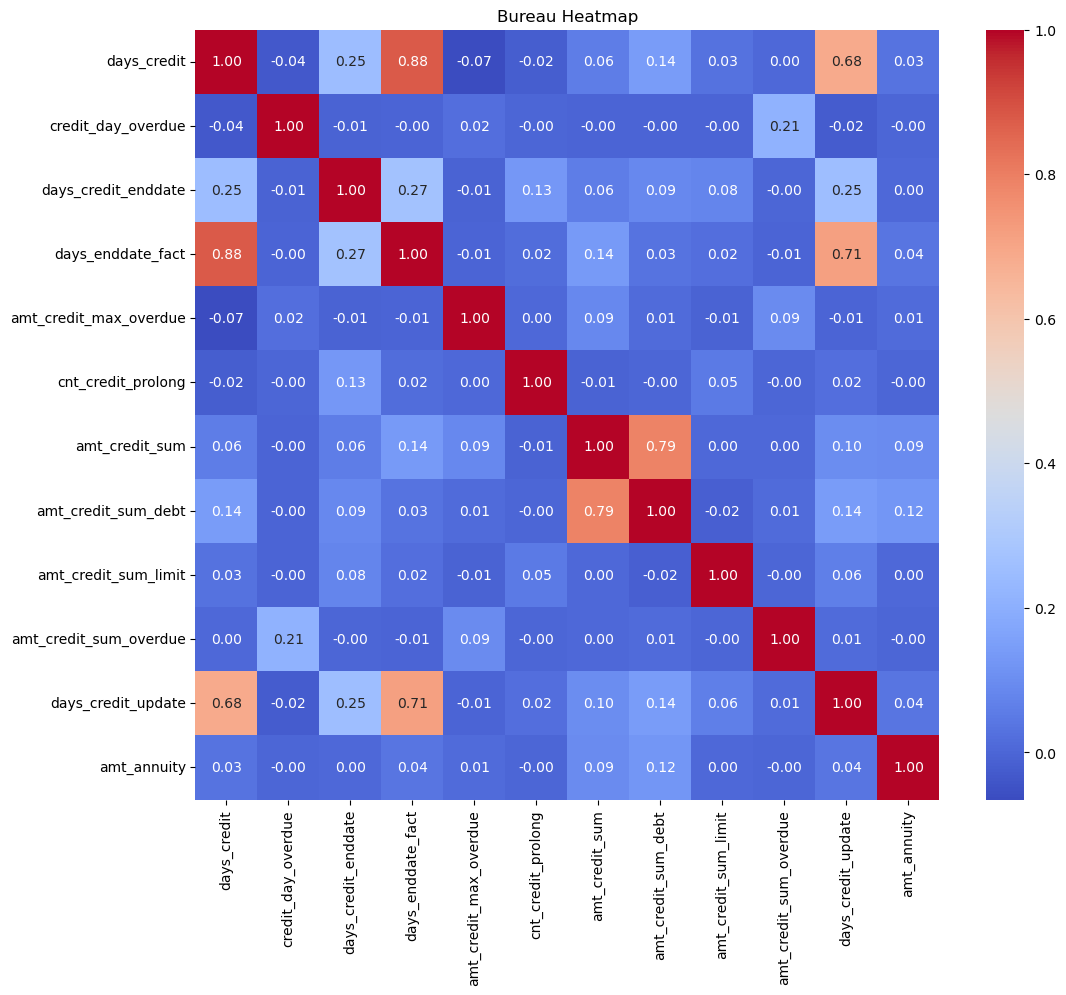

In [16]:
# Numerical columns for Bureau DF heatmap
numerical_columns = ['days_credit', 'credit_day_overdue', 'days_credit_enddate',
                     'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
                     'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit',
                     'amt_credit_sum_overdue', 'days_credit_update', 'amt_annuity']

subset_df = bureau_df[numerical_columns]

# Correlation matrix
corr_matrix = subset_df.corr()

# Create Bureau heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Bureau Heatmap')
plt.show()

In [17]:
bureau_null_values = bureau_df.isnull().sum()
bureau_null_values

sk_id_curr                    1
sk_id_bureau                  1
credit_active                 0
credit_currency               0
days_credit                   1
credit_day_overdue            1
days_credit_enddate        1889
days_enddate_fact         11211
amt_credit_max_overdue    19160
cnt_credit_prolong            1
amt_credit_sum                1
amt_credit_sum_debt        4760
amt_credit_sum_limit      10236
amt_credit_sum_overdue        1
credit_type                   0
days_credit_update            1
amt_annuity               24034
dtype: int64

In [32]:
bureau_df.describe()

,sk_id_curr,sk_id_bureau,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,days_credit_update,amt_annuity
count,29999.000000,2.999900e+04,29999.000000,29999.000000,28111.000000,18789.000000,1.084000e+04,29999.000000,2.999900e+04,2.524000e+04,1.976400e+04,29999.000000,29999.000000,5.966000e+03
mean,279299.469516,5.832989e+06,-1153.303677,1.518217,448.106008,-1037.443930,3.472898e+03,0.007000,3.727391e+05,1.372857e+05,6.827422e+03,60.477420,-604.968766,1.501516e+04
std,103059.131158,4.175040e+05,804.752199,50.987860,4803.352678,722.791162,3.714300e+04,0.104651,1.304878e+06,6.899328e+05,4.723217e+04,3393.627067,743.523186,9.209780e+04
min,100045.000000,5.373124e+06,-2922.000000,0.000000,-41845.000000,-2892.000000,0.000000e+00,0.000000,0.000000e+00,-7.742362e+05,-1.102936e+05,0.000000,-41925.000000,0.000000e+00
25%,188963.000000,5.714750e+06,-1693.000000,0.000000,-1169.000000,-1541.000000,0.000000e+00,0.000000,5.311350e+04,0.000000e+00,0.000000e+00,0.000000,-910.000000,0.000000e+00
50%,281717.000000,5.723800e+06,-996.000000,0.000000,-334.000000,-905.000000,0.000000e+00,0.000000,1.305000e+05,0.000000e+00,0.000000e+00,0.000000,-406.000000,0.000000e+00
75%,369029.000000,6.071934e+06,-470.000000,0.000000,476.000000,-434.000000,0.000000e+00,0.000000,3.150000e+05,3.829147e+04,0.000000e+00,0.000000,-34.000000,1.350000e+04
max,456230.000000,6.729719e+06,-2.000000,2625.000000,31196.000000,0.000000,3.292848e+06,5.000000,1.125000e+08,4.306433e+07,1.910681e+06,349428.060000,0.000000,4.358508e+06


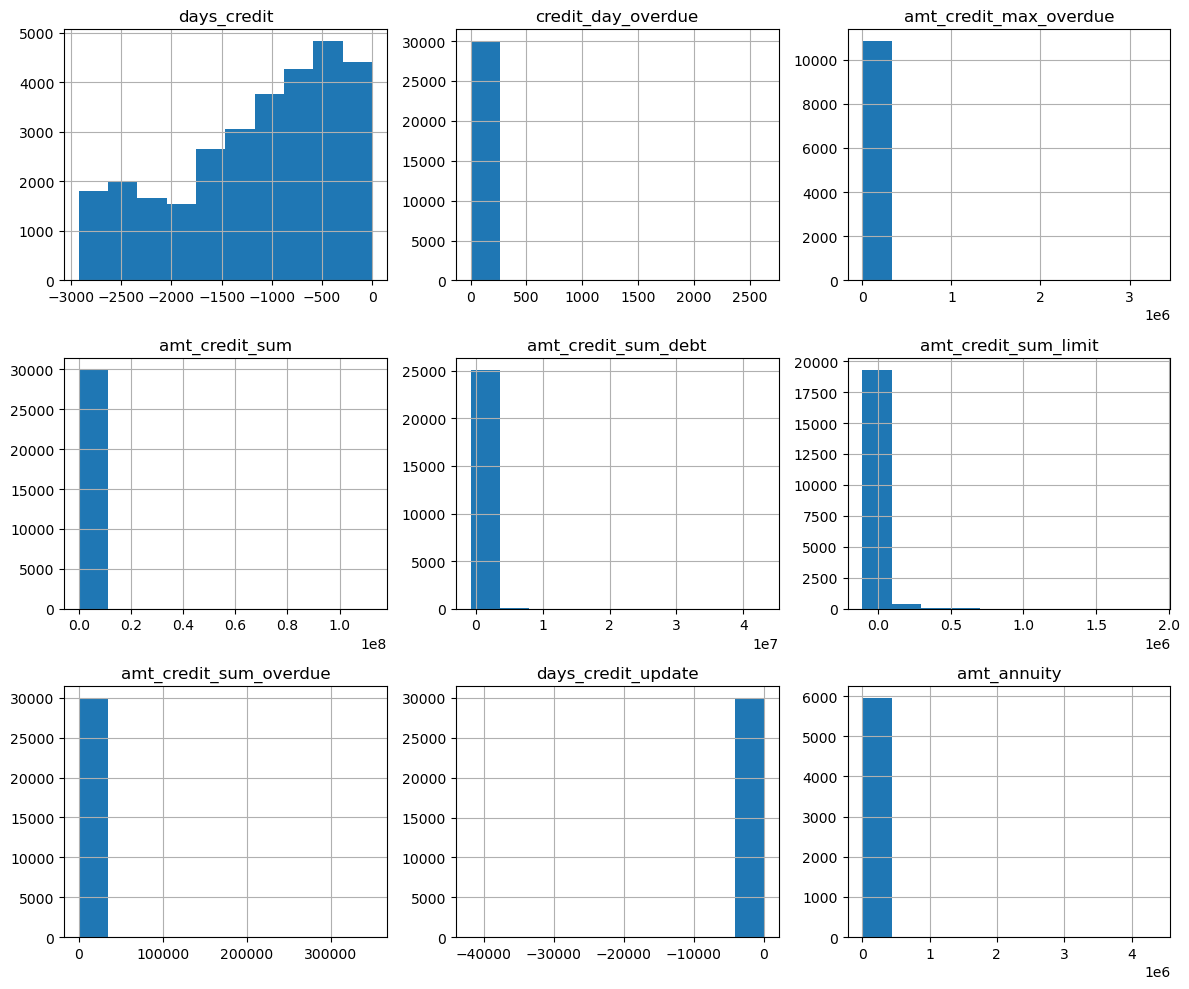

In [19]:
hist_bureau_df = bureau_df[['days_credit', 'credit_day_overdue', 'amt_credit_max_overdue', 'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit', 'amt_credit_sum_overdue', 'days_credit_update', 'amt_annuity']]

# Plot histograms for each column in the subset DataFrame
hist_bureau_df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

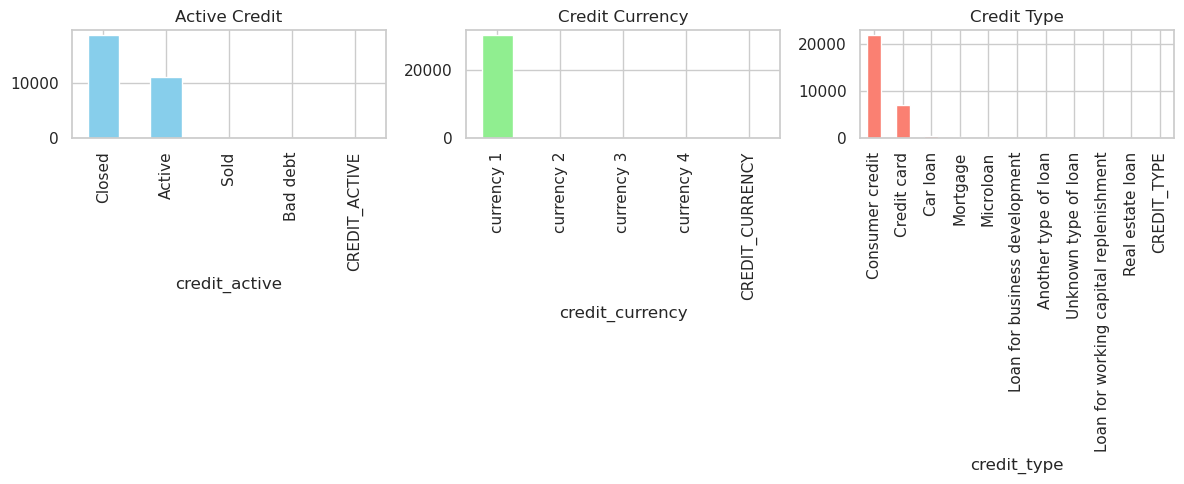

In [33]:
# Categorical columns
categorical_subset = bureau_df[['credit_active', 'credit_currency', 'credit_type']]

# Plot bar charts for each categorical variable
plt.figure(figsize=(12, 5))

# Plot for credit_active
plt.subplot(1, 3, 1)
categorical_subset['credit_active'].value_counts().plot(title = 'Active Credit', kind='bar', color='skyblue')

# Plot for credit_currency
plt.subplot(1, 3, 2)
categorical_subset['credit_currency'].value_counts().plot(title = 'Credit Currency', kind='bar', color='lightgreen')

# Plot for credit_type
plt.subplot(1, 3, 3)
categorical_subset['credit_type'].value_counts().plot(title = 'Credit Type', kind='bar', color='salmon')

plt.tight_layout()
plt.show()

Previous Application EDA

In [21]:
prev_app_df

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2302055.0,345579.0,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,10.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1,2302031.0,134074.0,Revolving loans,NaN,0.0,0.0,NaN,NaN,SUNDAY,13.0,...,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
2,1877823.0,313536.0,Consumer loans,11935.350,54531.0,57411.0,0.0,54531.0,THURSDAY,12.0,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-246.0,-96.0,-96.0,-92.0,0.0
3,2499286.0,221907.0,Consumer loans,6262.875,57861.0,56371.5,5787.0,57861.0,MONDAY,16.0,...,Consumer electronics,10.0,low_normal,POS household without interest,365243.0,-2540.0,-2270.0,-2270.0,-2250.0,1.0
4,1866043.0,315697.0,Consumer loans,8763.615,89991.0,90346.5,9000.0,89991.0,WEDNESDAY,11.0,...,Consumer electronics,14.0,high,POS household with interest,365243.0,-2057.0,-1667.0,-1697.0,-1692.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2044062.0,410986.0,Consumer loans,3811.680,17311.5,14305.5,3465.0,17311.5,SATURDAY,14.0,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-1269.0,-1179.0,-1179.0,-1173.0,0.0
29996,1337326.0,220466.0,Consumer loans,2436.615,16875.0,18265.5,0.0,16875.0,THURSDAY,14.0,...,Connectivity,10.0,high,POS mobile with interest,365243.0,-2494.0,-2224.0,-2224.0,-2221.0,1.0
29997,1456896.0,412826.0,Cash loans,23055.750,225000.0,225000.0,NaN,225000.0,MONDAY,17.0,...,Connectivity,12.0,middle,Cash X-Sell: middle,365243.0,-448.0,-118.0,-118.0,-115.0,0.0
29998,2845021.0,164767.0,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,11.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
prev_app_null_values = prev_app_df.isnull().sum()
prev_app_null_values

sk_id_prev                         1
sk_id_curr                         1
name_contract_type                 0
amt_annuity                    10640
amt_application                    1
amt_credit                         1
amt_down_payment               13501
amt_goods_price                 7658
weekday_appr_process_start         0
hour_appr_process_start            1
flag_last_appl_per_contract        0
nflag_last_appl_in_day           788
rate_down_payment              15134
rate_interest_primary          24805
rate_interest_privileged       29904
name_cash_loan_purpose             0
name_contract_status               0
days_decision                   5100
name_payment_type               5099
code_reject_reason              5099
name_type_suite                 5099
name_client_type                5099
name_goods_category             5099
name_portfolio                  5099
name_product_type               5099
channel_type                    5099
sellerplace_area                6123
n

In [23]:
prev_app_df.describe()

,sk_id_prev,sk_id_curr,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,...,rate_interest_privileged,days_decision,sellerplace_area,cnt_payment,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
count,2.999900e+04,2.999900e+04,19360.000000,2.999900e+04,2.999900e+04,16499.000000,2.234200e+04,29999.000000,2.921200e+04,14866.000000,...,96.000000,24900.000000,23877.000000,18359.000000,14187.000000,15025.000000,15025.000000,15025.000000,15025.000000,15025.000000
mean,1.643982e+06,1.339890e+06,15791.705159,1.429110e+05,1.600916e+05,4778.207251,1.920520e+05,10.350778,2.535700e+04,1300.018312,...,0.796963,-886.514297,249.633036,15.844926,340610.040882,34458.559268,34369.418170,73701.599667,81917.123195,2416.848053
std,7.852552e+05,2.355230e+06,14817.000405,2.730349e+05,2.983107e+05,14550.167151,3.011418e+05,5.586842,3.709928e+05,21199.771783,...,0.085052,785.981367,1014.752920,14.556103,91746.270109,108444.344837,107731.531965,147563.857587,153260.517760,29999.217626
min,1.001790e+05,1.000060e+05,0.000000,-2.921000e+03,0.000000e+00,-2792.000000,-2.893000e+03,0.000000,-9.021000e+03,0.000000,...,0.513742,-2922.000000,-1.000000,0.000000,-2908.000000,-2891.000000,-2889.000000,-2820.000000,-2857.000000,-2745.000000
25%,1.173396e+06,2.088050e+05,6244.278750,0.000000e+00,0.000000e+00,0.000000,3.405825e+04,8.000000,1.000000e+00,0.000000,...,0.715645,-1319.000000,-1.000000,6.000000,365243.000000,-1532.000000,-1283.000000,-1315.000000,-1269.000000,0.000000
50%,1.733696e+06,3.148270e+05,11093.737500,4.500000e+04,5.041800e+04,0.000000,8.796870e+04,11.000000,1.000000e+00,0.000000,...,0.835095,-576.000000,2.000000,12.000000,365243.000000,-734.000000,-381.000000,-530.000000,-496.000000,0.000000
75%,2.294210e+06,4.219165e+05,20277.505500,1.394640e+05,1.620000e+05,4950.000000,2.177775e+05,14.000000,1.000000e+00,0.106764,...,0.852537,-285.000000,72.000000,24.000000,365243.000000,-331.000000,123.000000,-71.000000,-45.000000,1.000000
max,2.845361e+06,6.732629e+06,212152.280000,4.455000e+06,4.050000e+06,720000.000000,4.455000e+06,23.000000,2.362500e+07,886645.900000,...,0.867336,-2.000000,30200.000000,84.000000,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000


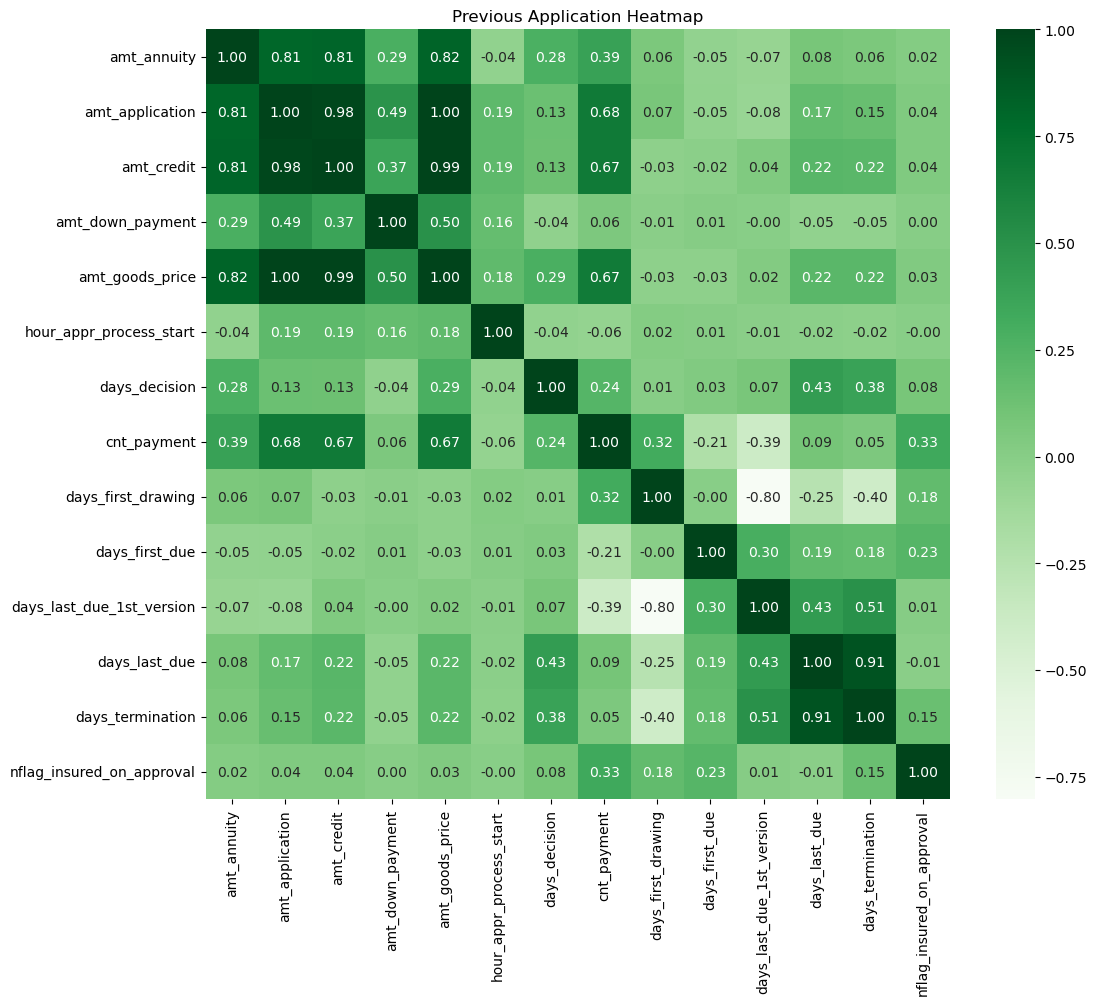

In [24]:
# Numerical columns for Previous App DF heatmap
numerical_columns = ['amt_annuity', 'amt_application', 'amt_credit', 'amt_down_payment',
                     'amt_goods_price', 'hour_appr_process_start', 'days_decision',
                     'cnt_payment', 'days_first_drawing', 'days_first_due',
                     'days_last_due_1st_version', 'days_last_due', 'days_termination',
                     'nflag_insured_on_approval']

subset_df = prev_app_df[numerical_columns]

# Correlation matrix
corr_matrix = subset_df.corr()

# Create a Previous App heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Previous Application Heatmap')
plt.show()

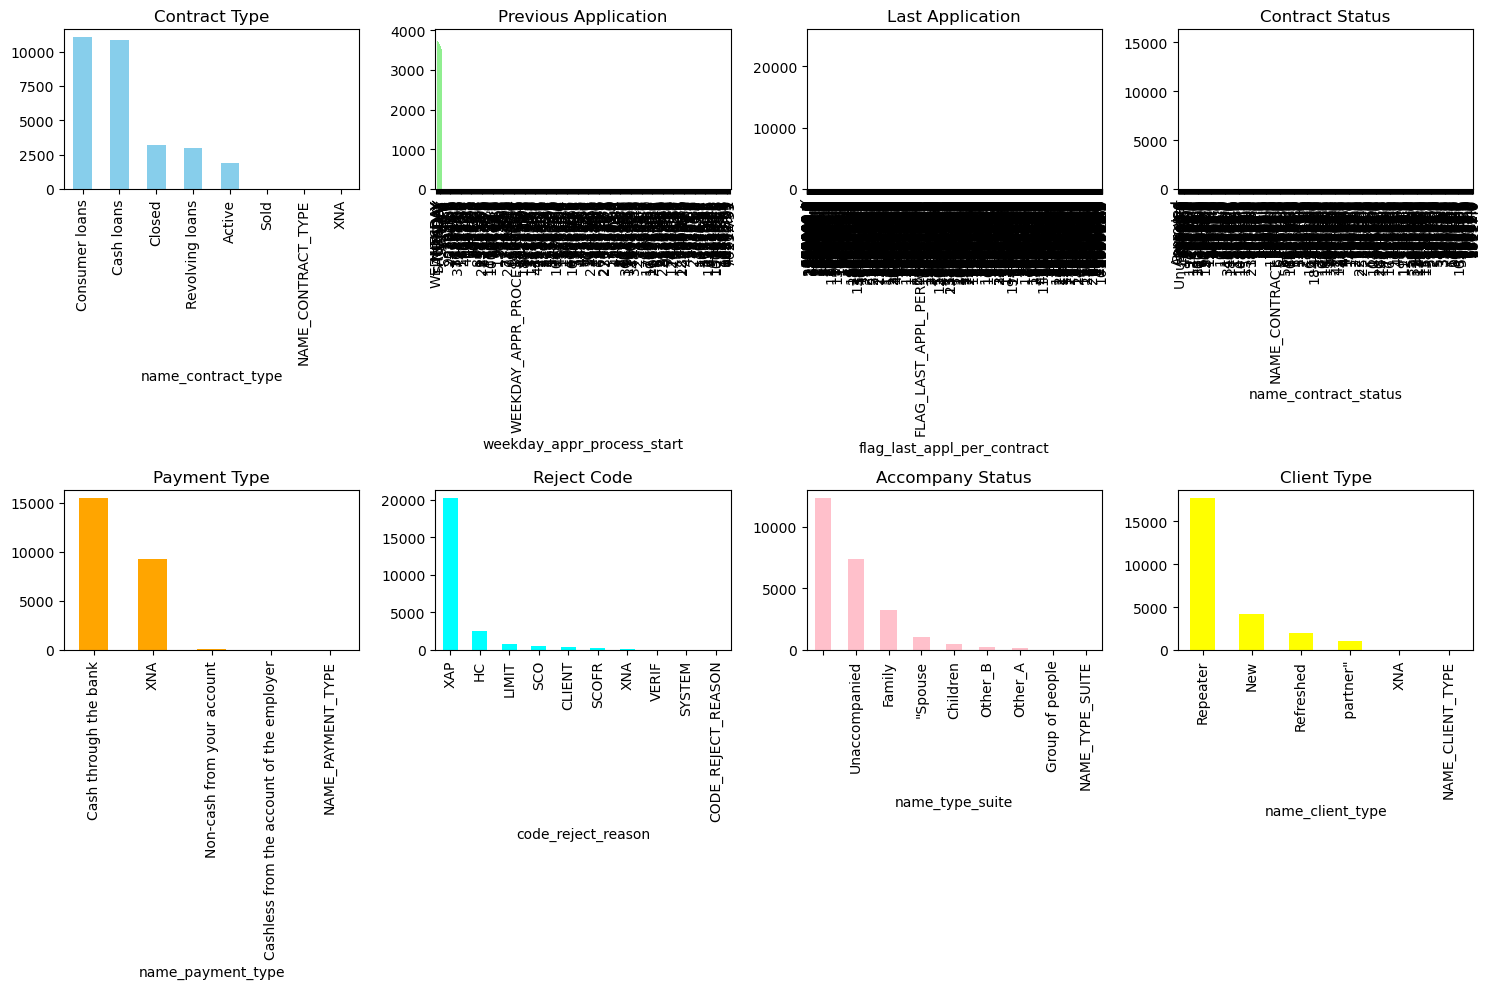

In [25]:
# Categorical Columns
categorical_columns = ['name_contract_type', 'weekday_appr_process_start', 'flag_last_appl_per_contract', 'name_contract_status',
                       'name_payment_type', 'code_reject_reason', 'name_type_suite', 'name_client_type']

# Subset the DataFrame to include only the categorical columns
categorical_subset = prev_app_df[categorical_columns]

# Plot for each categorical column
plt.figure(figsize=(15, 10))

# Contract Type Plot
plt.subplot(2, 4, 1)
categorical_subset['name_contract_type'].value_counts().plot(title = 'Contract Type', kind='bar', color='skyblue')

# Apply for Previous Application Plot
plt.subplot(2, 4, 2)
categorical_subset['weekday_appr_process_start'].value_counts().plot(title = 'Previous Application', kind='bar', color='lightgreen')

# Flag for Last Application of Previous Application Plot
plt.subplot(2, 4, 3)
categorical_subset['flag_last_appl_per_contract'].value_counts().plot(title = 'Last Application', kind='bar', color='salmon')

# Contract Status Plot
plt.subplot(2, 4, 4)
categorical_subset['name_contract_status'].value_counts().plot(title = 'Contract Status', kind='bar', color='purple')

# Payment Type Plot
plt.subplot(2, 4, 5)
categorical_subset['name_payment_type'].value_counts().plot(title = 'Payment Type', kind='bar', color='orange')

# Reject Code Plot
plt.subplot(2, 4, 6)
categorical_subset['code_reject_reason'].value_counts().plot(title = 'Reject Code', kind='bar', color='cyan')

# Accompany Status When Applying Plot
plt.subplot(2, 4, 7)
categorical_subset['name_type_suite'].value_counts().plot(title = 'Accompany Status', kind='bar', color='pink')

# Client Type Plot
plt.subplot(2, 4, 8)
categorical_subset['name_client_type'].value_counts().plot(title = 'Client Type', kind='bar', color='yellow')

plt.tight_layout()
plt.show()

Application EDA

In [26]:
app_df

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,391219.0,5133614.0,Active,currency 1,-2194,0,-1982.0,-2194.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,391219.0,5133615.0,Closed,currency 1,-2148,0,-1936.0,-1964.0,5670.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,391219.0,5133617.0,Active,currency 1,-517,0,244.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,391219.0,5133618.0,Closed,currency 1,-952,0,6353.0,-643.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,391219.0,5133619.0,Closed,currency 1,-1544,0,282.0,-1060.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,173353.0,0.0,Cash loans,M,N,N,0.0,202500.0,454500.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
29996,173354.0,0.0,Cash loans,M,N,Y,0.0,270000.0,1800000.0,62568.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29997,173355.0,0.0,Cash loans,F,Y,Y,0.0,72000.0,239850.0,23494.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29998,173356.0,0.0,Cash loans,F,N,Y,0.0,202500.0,189621.0,9252.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
app_null_values = app_df.isnull().sum()
app_null_values

sk_id_curr                        2
target                            2
name_contract_type                0
code_gender                       0
flag_own_car                      0
                              ...  
amt_req_credit_bureau_day     24726
amt_req_credit_bureau_week    24730
amt_req_credit_bureau_mon     24730
amt_req_credit_bureau_qrt     24730
amt_req_credit_bureau_year    24730
Length: 122, dtype: int64

In [28]:
app_df.describe()

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,2.999800e+04,2.999800e+04,22534.000000,2.284900e+04,1.025900e+04,29998.000000,1.725200e+04,8069.000000,18844.000000,6108.000000,...,6108.000000,6108.000000,6108.000000,6108.000000,5481.000000,5274.000000,5270.000000,5270.000000,5270.000000,5270.000000
mean,9.772714e+05,2.199602e+06,1997.927088,1.373046e+05,3.569121e+05,5531.267318,4.141249e+05,3273.893951,-5594.617173,61511.614768,...,0.006549,0.002947,0.000655,0.000491,0.004196,0.006068,0.028463,0.198861,0.266034,1.528273
std,8.936775e+05,2.632770e+06,8931.815035,2.234400e+05,4.190859e+05,12633.181570,7.394427e+05,21849.561419,7468.926134,140026.178845,...,0.080666,0.054210,0.025584,0.022158,0.072625,0.093203,0.182625,0.742342,0.643967,1.813536
min,1.000020e+05,0.000000e+00,-41845.000000,-2.892000e+03,0.000000e+00,0.000000,0.000000e+00,0.000000,-25201.000000,-25050.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.455712e+05,1.398470e+05,-213.750000,-3.030000e+02,0.000000e+00,0.000000,8.512425e+04,0.007274,-11598.750000,-3050.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.873015e+05,3.477705e+05,0.000000,8.100000e+04,2.340000e+05,11.000000,2.250000e+05,0.018850,-1154.000000,-1276.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.779610e+06,5.374164e+06,543.750000,1.707300e+05,5.850000e+05,17.000000,4.950000e+05,0.031329,-374.000000,-320.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,2.845133e+06,6.728517e+06,369922.000000,3.150000e+06,2.606400e+06,134604.000000,3.150000e+07,722889.000000,0.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,4.000000,16.000000,11.000000,18.000000


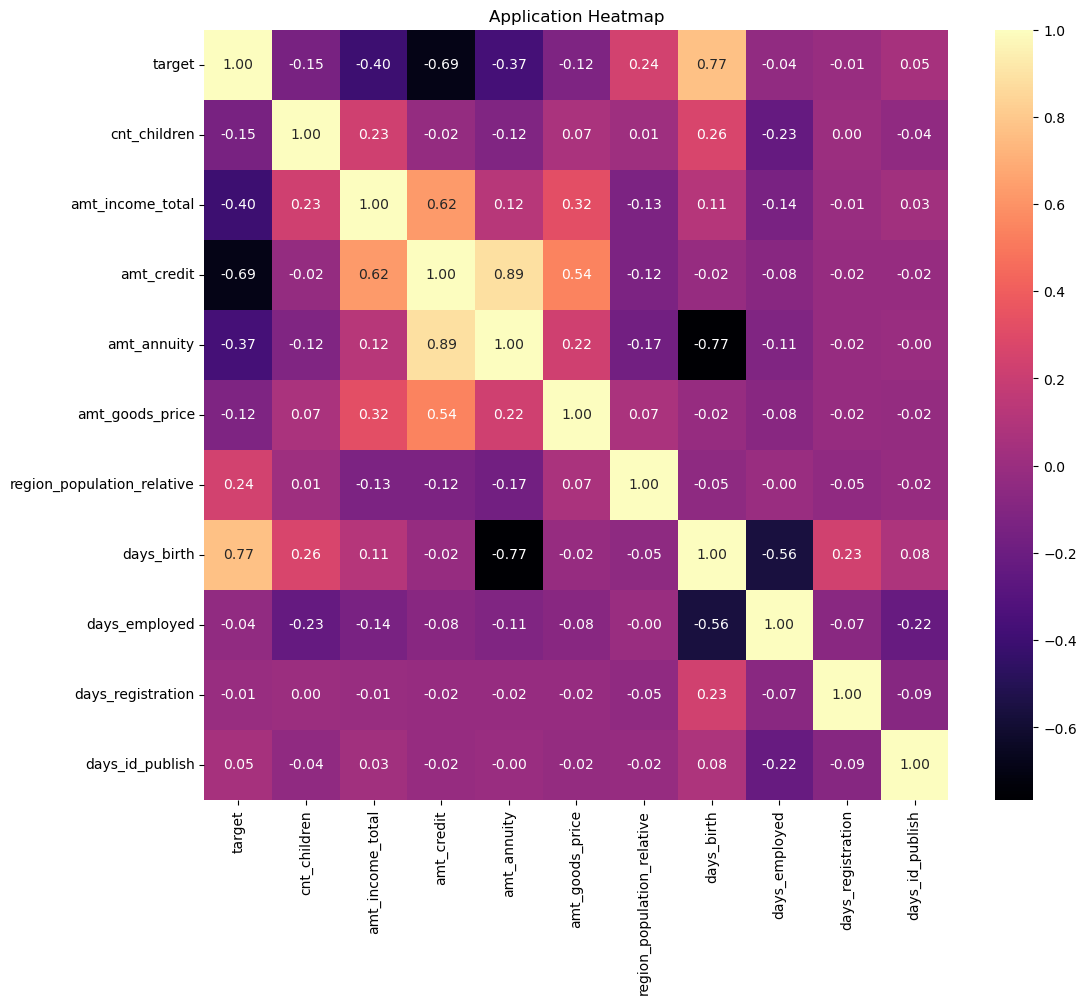

In [29]:
# Numerical columns for App DF heatmap
numerical_columns = ['target', 'cnt_children', 'amt_income_total',
                     'amt_credit', 'amt_annuity', 'amt_goods_price', 'region_population_relative',
                     'days_birth', 'days_employed', 'days_registration', 'days_id_publish']

subset_df = app_df[numerical_columns]

# Correlation matrix
corr_matrix = subset_df.corr()

# Create Application heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f")
plt.title('Application Heatmap')
plt.show()